In [ ]:
%pip install pytorch_lightning

# Importing required packages

In [25]:
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger

import pandas as pd
import numpy as np
import requests

In [26]:
file_name = "Transformers.csv"

url = "https://www.dropbox.com/scl/fi/24nzzwqm7rkhhjaaugeb9/transformer_data1.csv?rlkey=bo3jf4ee5iuhpjlbf339mp46v&st=6chs9rl7&dl=1"

response = requests.get(url)

# Save the file locally
with open(file_name, 'wb') as file:
    file.write(response.content)

In [27]:
# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(file_name)

# df['Total_Activations_Batch_Size'] = df['Total Activations'] * df['Batch Size']
df.loc[df['Status'] == 'OOM_CRASH', 'Max GPU Memory (MiB)'] = 42000


df = df[['Depth', 'Batch Size', 'Activations-Params', 'Total Activations', 'Total Parameters',
       'Max GPU Memory (MiB)', 'NonDynamicallyQuantizableLinear Count',
       'Linear Count', 'LayerNorm Count', 'Dropout Count']]

print('max layers: ', df['Depth'].max(), 'min: ', df['Depth'].min())
print('max parameters: ', df['Total Parameters'].max(), 'min: ', df['Total Parameters'].min())
print('max activations: ', df['Total Activations'].max(), 'min: ', df['Total Activations'].min())
print('max batch_size: ', df['Batch Size'].max(), 'min: ', df['Batch Size'].min())
print('max gpumemory_max: ', df['Max GPU Memory (MiB)'].max(), 'min: ', df['Max GPU Memory (MiB)'].min())
print('len dataset: ', len(df), df.columns)

max layers:  314 min:  18
max parameters:  2953687054 min:  0
max activations:  3194470 min:  19184
max batch_size:  128 min:  1
max gpumemory_max:  42000 min:  1683
len dataset:  5011 Index(['Depth', 'Batch Size', 'Activations-Params', 'Total Activations',
       'Total Parameters', 'Max GPU Memory (MiB)',
       'NonDynamicallyQuantizableLinear Count', 'Linear Count',
       'LayerNorm Count', 'Dropout Count'],
      dtype='object')


In [28]:
import ast

# 'Depth', 'Batch Size', 'Activations-Params', 'Total Activations', 'Total Parameters',
#        'Max GPU Memory (MiB)', 'NonDynamicallyQuantizableLinear Count',
#        'Linear Count', 'LayerNorm Count', 'Dropout Count'

# Reset the index to ensure it is in the default integer format
df = df.reset_index(drop=True)

max_layer = 0

# Check if the column 'params_activations_list' exists
if 'Activations-Params' in df.columns:
    for i in range(len(df)):
        try:
            # Check if the entry is already a list; if not, use ast.literal_eval to convert it
            entry = df['Activations-Params'].iloc[i]  # Use iloc to access the row by position

            if isinstance(entry, str):
                current_list = ast.literal_eval(entry)
            else:
                current_list = entry

            # Ensure the parsed content is a list
            if isinstance(current_list, list):
                l = len(current_list)
                if l > max_layer:
                    max_layer = l
            else:
                print(f"Unexpected format at index {i}: {entry}")

        except (ValueError, SyntaxError) as e:
            print(f"Error processing entry at index {i}: {entry} - {e}")

    print('Maximum layers:', max_layer)
else:
    print("Column 'params_activations_list' does not exist in the DataFrame.")


Maximum layers: 314


In [29]:
df

,Depth,Batch Size,Activations-Params,Total Activations,Total Parameters,Max GPU Memory (MiB),NonDynamicallyQuantizableLinear Count,Linear Count,LayerNorm Count,Dropout Count
0,66,64,"[('Embedding', 4194304, 70898304), ('Linear', ...",77265,71621233,5217,8,25,16,24
1,74,8,"[('Embedding', 262144, 34258688), ('Linear', 1...",46442,35133650,2297,9,28,18,27
2,18,32,"[('Embedding', 12582912, 538338816), ('Linear'...",409637,543883815,13503,2,7,4,6
3,74,64,"[('Embedding', 4194304, 312577024), ('Linear',...",123176,327971308,10249,9,28,18,27
4,42,8,"[('Embedding', 4194304, 785974272), ('Linear',...",584133,815838567,18163,5,16,10,15
...,...,...,...,...,...,...,...,...,...,...
5006,242,64,"[('Embedding', 4194304, 122334208), ('Linear',...",145462,131054470,11551,30,91,60,90
5007,82,128,"[('Embedding', 134217728, 1732401152), ('Linea...",1275709,0,42000,10,31,20,30
5008,122,8,"[('Embedding', 1048576, 408578048), ('Linear',...",332427,520525423,12945,15,46,30,45
5009,226,128,"[('Embedding', 2097152, 23830656), ('Linear', ...",61047,26824831,6091,28,85,56,84


In [30]:
bins = [0, 8000, 16000, 24000, 32000, 40000, 50000]
labels = [i for i in range(0, len(bins) - 1)]
print(bins, labels)
# Use pd.cut() to create a new column with labels based on the bins
df['memory_usage_label'] = pd.cut(df['Max GPU Memory (MiB)'], bins=bins, labels=labels, right=False)

df.head()

[0, 8000, 16000, 24000, 32000, 40000, 50000] [0, 1, 2, 3, 4, 5]


,Depth,Batch Size,Activations-Params,Total Activations,Total Parameters,Max GPU Memory (MiB),NonDynamicallyQuantizableLinear Count,Linear Count,LayerNorm Count,Dropout Count,memory_usage_label
0,66,64,"[('Embedding', 4194304, 70898304), ('Linear', ...",77265,71621233,5217,8,25,16,24,0
1,74,8,"[('Embedding', 262144, 34258688), ('Linear', 1...",46442,35133650,2297,9,28,18,27,0
2,18,32,"[('Embedding', 12582912, 538338816), ('Linear'...",409637,543883815,13503,2,7,4,6,1
3,74,64,"[('Embedding', 4194304, 312577024), ('Linear',...",123176,327971308,10249,9,28,18,27,1
4,42,8,"[('Embedding', 4194304, 785974272), ('Linear',...",584133,815838567,18163,5,16,10,15,2


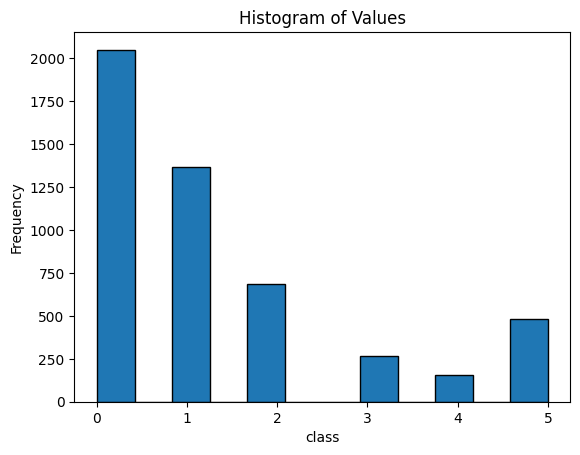

In [31]:
# Plot the histogram
import matplotlib.pyplot as plt

plt.hist(df['memory_usage_label'], bins=len(labels)*2, edgecolor='black')  # bins can be adjusted
plt.title('Histogram of Values')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.show()

In [32]:
# 'Depth', 'Batch Size', 'Activations-Params', 'Total Activations', 'Total Parameters',
#        'Max GPU Memory (MiB)', 'NonDynamicallyQuantizableLinear Count',
#        'Linear Count', 'LayerNorm Count', 'Dropout Count'

print(df.columns)
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    df[['Activations-Params','Depth', 'Batch Size', 'Total Activations', 'Total Parameters',
        'NonDynamicallyQuantizableLinear Count', 'Linear Count', 'LayerNorm Count', 'Dropout Count'
       ]].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df))
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

Index(['Depth', 'Batch Size', 'Activations-Params', 'Total Activations',
       'Total Parameters', 'Max GPU Memory (MiB)',
       'NonDynamicallyQuantizableLinear Count', 'Linear Count',
       'LayerNorm Count', 'Dropout Count', 'memory_usage_label'],
      dtype='object')
total data size:  5011
train size 3507, val size: 993, test size: 511


In [33]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

def encode_layer_cnn(layer_type):
    if layer_type == 'Embedding':
        return [0, 0, 0]
    elif layer_type == 'NonDynamicallyQuantizableLinear':
        return [0, 0, 1]
    elif layer_type == 'LayerNorm':
        return [0, 1, 0]
    elif layer_type == 'Dropout':
        return [0, 1, 1]
    elif layer_type == 'Linear':
        return [1, 0, 0]
    else:
        print(layer_type)
        raise ValueError("Unknown layer type")

# Function to process each sequence
def process_sequence(sequence):
    # print(sequence)
    processed_sequence = []
    for entry in eval(sequence):  # Evaluate string as list of tuples
        layer_type, feature_1, feature_2 = entry
        # for fc
        # encoded_layer = encode_layer(layer_type)
        # for cnn
        encoded_layer = encode_layer_cnn(layer_type)
        combined = encoded_layer + [feature_1, feature_2]
        processed_sequence.append(combined)
    return np.array(processed_sequence)

def get_filtered_lists(list1, list2, list3):
    filtered_list1, filtered_list2, filtered_list3 = zip(*[(l1, l2, l3) for l1, l2, l3 in zip(list1, list2, list3) if len(l1) > 0])
    return filtered_list1, filtered_list2, filtered_list3

# Dataset preparation
class LayerSequenceDataset(Dataset):
    def __init__(self, x_data, y_labels, max_seq_len):
        self.x_data = [process_sequence(seq[0]) for seq in x_data]
        self.batch_size = [np.array(seq[1:]).astype(np.int64) for seq in x_data]
        self.y_labels = y_labels
        self.x_data, self.batch_size, self.y_labels = get_filtered_lists(self.x_data, self.batch_size, self.y_labels)
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        sequence = self.x_data[idx]
        batch_size = self.batch_size[idx]
        label = self.y_labels[idx]
        # Padding sequences to max length
        if len(sequence) < self.max_seq_len:
            padded_sequence = np.pad(sequence, ((0, self.max_seq_len - len(sequence)), (0,0)), 'constant')
        else:
            padded_sequence = sequence[:self.max_seq_len]


        return torch.tensor(padded_sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(batch_size, dtype=torch.float32)



# Example Usage
max_seq_len = max_layer  # Set the max sequence length based on your data
x_train = np.array(x_train)  # Your input sequences here
y_train = np.array(y_train)  # Your labels here

# Initialize dataset and dataloader
train_dataset = LayerSequenceDataset(x_train, y_train, max_seq_len)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = LayerSequenceDataset(x_val, y_val, max_seq_len)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = LayerSequenceDataset(x_test, y_test, max_seq_len)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

inputs, label_sample, batch_sample = next(iter(train_dataloader))
print(inputs.shape, label_sample.shape, batch_sample.shape)


torch.Size([128, 314, 5]) torch.Size([128]) torch.Size([128, 8])


# model

In [34]:
from pytorch_lightning import seed_everything

seed = 11  # Set your desired seed
seed_everything(seed, workers=True)
torch.use_deterministic_algorithms(False)


Seed set to 11


In [35]:
import torch.optim as optim

class TransformerClassifier(nn.Module):
    def __init__(self, num_features, num_classes, d_model, nhead, num_layers, dim_feedforward, dropout, max_seq_len):
        super(TransformerClassifier, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Sequential(nn.Linear(num_features, d_model),  # Embedding layer for input features
                                        # nn.LayerNorm(d_model),
                                       nn.BatchNorm1d(max_seq_len),
                                       nn.ReLU(),
                                       nn.Linear(d_model, d_model),
                                       nn.BatchNorm1d(max_seq_len),
                                       nn.ReLU(),
                                       )
        # Positional Encoding
        self.positional_encoding = nn.Parameter(self._get_positional_encoding(max_seq_len, d_model), requires_grad=False)

        # Transformer layers
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)

        # Final classification layer
        self.fc_out = nn.Sequential(nn.Linear(d_model+8, d_model),
                                    nn.BatchNorm1d(d_model),
                                    nn.ReLU(),
                                    nn.Linear(d_model, num_classes),
        )

    def _get_positional_encoding(self, max_seq_len, d_model):
        pos_encoding = torch.zeros(max_seq_len, d_model)
        positions = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))

        pos_encoding[:, 0::2] = torch.sin(positions * div_term)
        pos_encoding[:, 1::2] = torch.cos(positions * div_term)

        return pos_encoding.unsqueeze(0)

    def forward(self, x, batch_size_feature):
        # Add positional encoding
        seq_len = x.size(1)
        x = self.embedding(x) + self.positional_encoding[:, :seq_len, :]

        # Transformer encoder
        x = self.transformer_encoder(x)

        # Classification (average pooling over sequence dimension)
        x = x.sum(dim=1)  # Pool over the sequence dimension

        # Ensure batch_size_feature has the correct shape
        batch_size_feature = batch_size_feature.unsqueeze(1) if batch_size_feature.dim() == 1 else batch_size_feature

        # batch_size_feature=batch_size_feature.unsqueeze(1)
        x = torch.cat((x, batch_size_feature), dim=1)

        # Output layer for classification
        output = self.fc_out(x)

        return output

In [49]:
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = TransformerClassifier(num_features=5, num_classes=len(labels), d_model=6, nhead=3,
                                           num_layers=3, dim_feedforward=8, dropout=0, max_seq_len=max_layer)
        self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x, b):
        return self.model(x, b)

    def training_step(self, batch, batch_idx):
        x, y, b = batch[0], batch[1], batch[2]
        y = y.long()
        logits = self.forward(x, b)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log('train_loss', loss, on_epoch=True, on_step=True)
        self.log('train_acc', acc, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, b = batch[0], batch[1], batch[2]
        y = y.long()
        logits = self.forward(x, b)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        self.log('val_acc', acc, on_epoch=True, on_step=True)
        return loss

    # def configure_optimizers(self):
    #     # Create a quantized optimizer
    #     optimizer = optim.AdamW(self.parameters(), lr=0.001)

    #     return optimizer

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.001)

        # Use a scheduler that doesn't require setting the learning rate explicitly
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)#, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'frequency': 1
            }
        }

In [50]:
class HistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the training loss and accuracy logged during the epoch
        self.train_losses.append(trainer.callback_metrics["train_loss"].item())
        self.train_accuracies.append(trainer.callback_metrics["train_acc"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Access the validation loss and accuracy logged during the epoch
        self.val_losses.append(trainer.callback_metrics["val_loss"].item())
        self.val_accuracies.append(trainer.callback_metrics["val_acc"].item())

    def plot_history(self):
        # Plot training and validation loss
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Training Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label="Training Accuracy")
        plt.plot(self.val_accuracies, label="Validation Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [51]:
# Initialize the history callback
history_callback = HistoryCallback()


early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=True, mode='min')
classifier_model = classification_gpu_usage(output_size = len(labels))
classifier_model.train()



classification_gpu_usage(
  (model): TransformerClassifier(
    (embedding): Sequential(
      (0): Linear(in_features=5, out_features=6, bias=True)
      (1): BatchNorm1d(314, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=6, out_features=6, bias=True)
      (4): BatchNorm1d(314, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
          )
          (linear1): Linear(in_features=6, out_features=8, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=8, out_features=6, bias=True)
          (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((6,)

In [52]:
trainer = pl.Trainer(
    max_epochs=600,  # you can set this higher, early stopping will halt training
    callbacks=[early_stopping, history_callback],
    # precision='16-mixed',  # Use AMP
    # accelerator='gpu',  # Use GPU if available
    # devices=1  # Number of GPUs
)

# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type                  | Params | Mode 
------------------------------------------------------------
0 | model     | TransformerClassifier | 4.3 K  | train
1 | criterion | CrossEntropyLoss      | 0      | train
------------------------------------------------------------
2.4 K     Trainable params
1.9 K     Non-trainable params
4.3 K     Total params
0.017     Total estimated mod

/opt/miniconda3/envs/dl/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/miniconda3/envs/dl/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/miniconda3/envs/dl/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 28/28 [00:01<00:00, 27.85it/s, v_num=10, val_loss_step=1.980, val_loss_epoch=2.020]

Metric val_loss improved. New best score: 2.024


Epoch 1: 100%|██████████| 28/28 [00:00<00:00, 29.69it/s, v_num=10, val_loss_step=1.880, val_loss_epoch=1.900]

Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 1.897


Epoch 2: 100%|██████████| 28/28 [00:00<00:00, 29.24it/s, v_num=10, val_loss_step=1.810, val_loss_epoch=1.810]

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 1.815


Epoch 3: 100%|██████████| 28/28 [00:00<00:00, 29.82it/s, v_num=10, val_loss_step=1.770, val_loss_epoch=1.770]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.774


Epoch 4: 100%|██████████| 28/28 [00:00<00:00, 29.00it/s, v_num=10, val_loss_step=1.740, val_loss_epoch=1.740]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.736


Epoch 5: 100%|██████████| 28/28 [00:00<00:00, 28.93it/s, v_num=10, val_loss_step=1.730, val_loss_epoch=1.720]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.720


Epoch 6: 100%|██████████| 28/28 [00:00<00:00, 28.77it/s, v_num=10, val_loss_step=1.700, val_loss_epoch=1.680]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.677


Epoch 7: 100%|██████████| 28/28 [00:00<00:00, 29.30it/s, v_num=10, val_loss_step=1.660, val_loss_epoch=1.640]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.640


Epoch 10: 100%|██████████| 28/28 [00:00<00:00, 28.52it/s, v_num=10, val_loss_step=1.660, val_loss_epoch=1.630]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.629


Epoch 11: 100%|██████████| 28/28 [00:00<00:00, 28.82it/s, v_num=10, val_loss_step=1.640, val_loss_epoch=1.610]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.606


Epoch 12: 100%|██████████| 28/28 [00:00<00:00, 29.02it/s, v_num=10, val_loss_step=1.620, val_loss_epoch=1.590]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.586


Epoch 13: 100%|██████████| 28/28 [00:00<00:00, 28.91it/s, v_num=10, val_loss_step=1.610, val_loss_epoch=1.570]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.570


Epoch 14: 100%|██████████| 28/28 [00:00<00:00, 28.11it/s, v_num=10, val_loss_step=1.580, val_loss_epoch=1.540]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.542


Epoch 15: 100%|██████████| 28/28 [00:00<00:00, 28.38it/s, v_num=10, val_loss_step=1.550, val_loss_epoch=1.510]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.510


Epoch 16: 100%|██████████| 28/28 [00:00<00:00, 28.37it/s, v_num=10, val_loss_step=1.490, val_loss_epoch=1.450]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.446


Epoch 17: 100%|██████████| 28/28 [00:00<00:00, 39.01it/s, v_num=10, val_loss_step=1.450, val_loss_epoch=1.410]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.406


Epoch 18: 100%|██████████| 28/28 [00:00<00:00, 38.30it/s, v_num=10, val_loss_step=1.420, val_loss_epoch=1.370]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.367


Epoch 19: 100%|██████████| 28/28 [00:00<00:00, 38.60it/s, v_num=10, val_loss_step=1.390, val_loss_epoch=1.330]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.332


Epoch 22: 100%|██████████| 28/28 [00:00<00:00, 38.93it/s, v_num=10, val_loss_step=1.300, val_loss_epoch=1.230]

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 1.235


Epoch 23: 100%|██████████| 28/28 [00:00<00:00, 38.96it/s, v_num=10, val_loss_step=1.270, val_loss_epoch=1.210]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.206


Epoch 24: 100%|██████████| 28/28 [00:00<00:00, 39.30it/s, v_num=10, val_loss_step=1.240, val_loss_epoch=1.180]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.176


Epoch 25: 100%|██████████| 28/28 [00:00<00:00, 39.38it/s, v_num=10, val_loss_step=1.220, val_loss_epoch=1.150]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.147


Epoch 26: 100%|██████████| 28/28 [00:00<00:00, 38.85it/s, v_num=10, val_loss_step=1.200, val_loss_epoch=1.130]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.130


Epoch 27: 100%|██████████| 28/28 [00:00<00:00, 28.41it/s, v_num=10, val_loss_step=1.180, val_loss_epoch=1.110]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.110


Epoch 28: 100%|██████████| 28/28 [00:00<00:00, 29.21it/s, v_num=10, val_loss_step=1.160, val_loss_epoch=1.090]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.089


Epoch 29: 100%|██████████| 28/28 [00:00<00:00, 28.24it/s, v_num=10, val_loss_step=1.150, val_loss_epoch=1.070]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.071


Epoch 30: 100%|██████████| 28/28 [00:00<00:00, 38.64it/s, v_num=10, val_loss_step=1.140, val_loss_epoch=1.060]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.057


Epoch 31: 100%|██████████| 28/28 [00:00<00:00, 38.39it/s, v_num=10, val_loss_step=1.120, val_loss_epoch=1.040]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.041


Epoch 34: 100%|██████████| 28/28 [00:00<00:00, 28.14it/s, v_num=10, val_loss_step=1.090, val_loss_epoch=1.010]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.012


Epoch 35: 100%|██████████| 28/28 [00:00<00:00, 28.23it/s, v_num=10, val_loss_step=1.090, val_loss_epoch=1.010]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.009


Epoch 36: 100%|██████████| 28/28 [00:00<00:00, 28.57it/s, v_num=10, val_loss_step=1.060, val_loss_epoch=0.988]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.988


Epoch 37: 100%|██████████| 28/28 [00:00<00:00, 28.52it/s, v_num=10, val_loss_step=1.040, val_loss_epoch=0.966]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.966


Epoch 39: 100%|██████████| 28/28 [00:00<00:00, 28.27it/s, v_num=10, val_loss_step=1.020, val_loss_epoch=0.952]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.952


Epoch 42: 100%|██████████| 28/28 [00:00<00:00, 29.36it/s, v_num=10, val_loss_step=1.000, val_loss_epoch=0.924]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.924


Epoch 43: 100%|██████████| 28/28 [00:00<00:00, 29.62it/s, v_num=10, val_loss_step=0.976, val_loss_epoch=0.904]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.904


Epoch 45: 100%|██████████| 28/28 [00:00<00:00, 30.27it/s, v_num=10, val_loss_step=0.977, val_loss_epoch=0.900]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.900


Epoch 49: 100%|██████████| 28/28 [00:00<00:00, 39.34it/s, v_num=10, val_loss_step=0.960, val_loss_epoch=0.896]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.896


Epoch 51: 100%|██████████| 28/28 [00:00<00:00, 29.80it/s, v_num=10, val_loss_step=0.950, val_loss_epoch=0.889]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.889


Epoch 52: 100%|██████████| 28/28 [00:00<00:00, 29.76it/s, v_num=10, val_loss_step=0.942, val_loss_epoch=0.867]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.867


Epoch 54: 100%|██████████| 28/28 [00:00<00:00, 28.85it/s, v_num=10, val_loss_step=0.930, val_loss_epoch=0.858]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.858


Epoch 56: 100%|██████████| 28/28 [00:00<00:00, 28.75it/s, v_num=10, val_loss_step=0.913, val_loss_epoch=0.842]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.842


Epoch 57: 100%|██████████| 28/28 [00:00<00:00, 45.66it/s, v_num=10, val_loss_step=0.873, val_loss_epoch=0.821]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.821


Epoch 59: 100%|██████████| 28/28 [00:00<00:00, 30.21it/s, v_num=10, val_loss_step=0.863, val_loss_epoch=0.798]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.798


Epoch 62: 100%|██████████| 28/28 [00:00<00:00, 29.68it/s, v_num=10, val_loss_step=0.825, val_loss_epoch=0.779]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.779


Epoch 63: 100%|██████████| 28/28 [00:00<00:00, 29.54it/s, v_num=10, val_loss_step=0.837, val_loss_epoch=0.772]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.772


Epoch 64: 100%|██████████| 28/28 [00:00<00:00, 30.03it/s, v_num=10, val_loss_step=0.796, val_loss_epoch=0.748]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.748


Epoch 66: 100%|██████████| 28/28 [00:00<00:00, 29.27it/s, v_num=10, val_loss_step=0.773, val_loss_epoch=0.736]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.736


Epoch 75: 100%|██████████| 28/28 [00:00<00:00, 29.04it/s, v_num=10, val_loss_step=0.760, val_loss_epoch=0.735]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.735


Epoch 78: 100%|██████████| 28/28 [00:00<00:00, 28.59it/s, v_num=10, val_loss_step=0.759, val_loss_epoch=0.735]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.735


Epoch 80: 100%|██████████| 28/28 [00:00<00:00, 28.94it/s, v_num=10, val_loss_step=0.761, val_loss_epoch=0.734]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.734


Epoch 84: 100%|██████████| 28/28 [00:00<00:00, 39.78it/s, v_num=10, val_loss_step=0.756, val_loss_epoch=0.732]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.732


Epoch 85: 100%|██████████| 28/28 [00:00<00:00, 39.56it/s, v_num=10, val_loss_step=0.755, val_loss_epoch=0.730]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.730


Epoch 87: 100%|██████████| 28/28 [00:00<00:00, 39.77it/s, v_num=10, val_loss_step=0.754, val_loss_epoch=0.727]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.727


Epoch 88: 100%|██████████| 28/28 [00:00<00:00, 37.54it/s, v_num=10, val_loss_step=0.751, val_loss_epoch=0.726]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.726


Epoch 92: 100%|██████████| 28/28 [00:00<00:00, 29.61it/s, v_num=10, val_loss_step=0.748, val_loss_epoch=0.723]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.723


Epoch 98: 100%|██████████| 28/28 [00:00<00:00, 28.83it/s, v_num=10, val_loss_step=0.750, val_loss_epoch=0.723]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.723


Epoch 100: 100%|██████████| 28/28 [00:00<00:00, 28.36it/s, v_num=10, val_loss_step=0.750, val_loss_epoch=0.720]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.720


Epoch 103: 100%|██████████| 28/28 [00:00<00:00, 28.52it/s, v_num=10, val_loss_step=0.743, val_loss_epoch=0.716]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.716


Epoch 108: 100%|██████████| 28/28 [00:00<00:00, 29.93it/s, v_num=10, val_loss_step=0.738, val_loss_epoch=0.714]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.714


Epoch 112: 100%|██████████| 28/28 [00:00<00:00, 29.44it/s, v_num=10, val_loss_step=0.735, val_loss_epoch=0.712]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.712


Epoch 117: 100%|██████████| 28/28 [00:00<00:00, 30.24it/s, v_num=10, val_loss_step=0.737, val_loss_epoch=0.711]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.711


Epoch 119: 100%|██████████| 28/28 [00:00<00:00, 28.07it/s, v_num=10, val_loss_step=0.742, val_loss_epoch=0.710]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.710


Epoch 125: 100%|██████████| 28/28 [00:00<00:00, 28.64it/s, v_num=10, val_loss_step=0.733, val_loss_epoch=0.708]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.708


Epoch 126: 100%|██████████| 28/28 [00:00<00:00, 28.80it/s, v_num=10, val_loss_step=0.736, val_loss_epoch=0.707]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.707


Epoch 127: 100%|██████████| 28/28 [00:00<00:00, 29.01it/s, v_num=10, val_loss_step=0.729, val_loss_epoch=0.704]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.704


Epoch 134: 100%|██████████| 28/28 [00:00<00:00, 28.83it/s, v_num=10, val_loss_step=0.723, val_loss_epoch=0.700]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.700


Epoch 135: 100%|██████████| 28/28 [00:00<00:00, 29.03it/s, v_num=10, val_loss_step=0.720, val_loss_epoch=0.698]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.698


Epoch 155: 100%|██████████| 28/28 [00:00<00:00, 29.36it/s, v_num=10, val_loss_step=0.729, val_loss_epoch=0.703]

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.698. Signaling Trainer to stop.


Epoch 155: 100%|██████████| 28/28 [00:00<00:00, 28.92it/s, v_num=10, val_loss_step=0.729, val_loss_epoch=0.703]


In [53]:
classifier_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader:
        pred = classifier_model(test_data[0],test_data[2])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(torch.argmax(pred, 1).item())

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)


Accuracy: 0.7632
Precision: 0.6930
Recall: 0.7632
F1-Score: 0.7258

Confusion Matrix:
[[205   8   0   0   0   2]
 [ 30  94   5   0   0   0]
 [  5  18  46   0   0   0]
 [  2  10  21   0   0   2]
 [  0   2   7   0   0   3]
 [  5   0   1   0   0  45]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       215
           1       0.71      0.73      0.72       129
           2       0.57      0.67      0.62        69
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00        12
           5       0.87      0.88      0.87        51

    accuracy                           0.76       511
   macro avg       0.50      0.54      0.52       511
weighted avg       0.69      0.76      0.73       511



/opt/miniconda3/envs/dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/minic

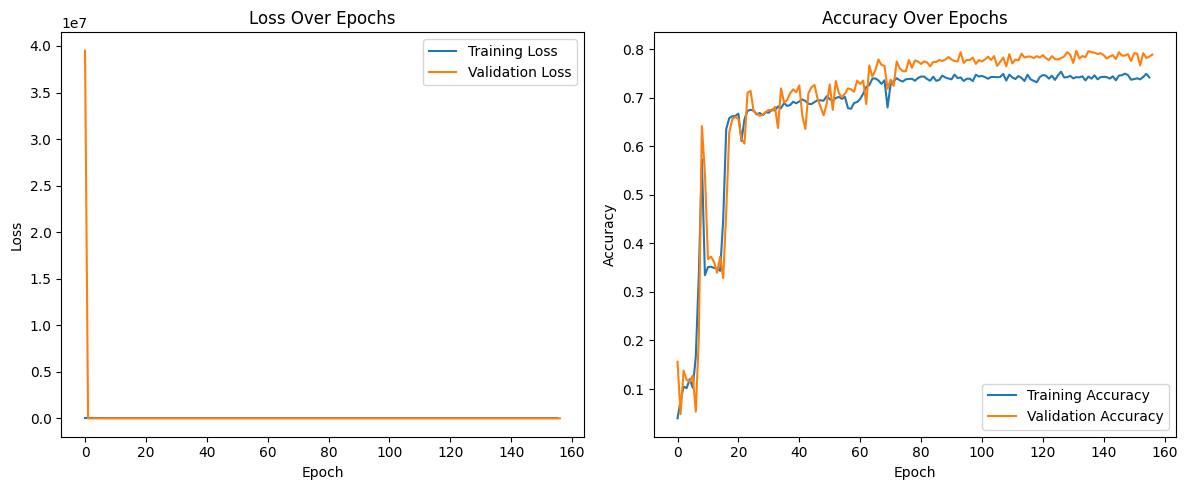

In [55]:
history_callback.plot_history()